## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: #########
* Instructor name: Jeff Herman
* Blog post URL: ###########


# Access TMDB database

Should movies be so long

This data project will investigate the relationship between the running time of a movie, and its potential revenue production.

In [451]:
# Access TMDB
import jsona
import pandas as pd

def get_keys(path):
    with open(path) as f:
        return json.load(f)
    

keys = get_keys("/Users/aaronlee/.secret/tmdb_api.json")

api_key = keys['api_key']
api_key4 = keys['api_key4']


In [452]:
import requests

# useful urls to access tmdb
base_url = 'https://api.themoviedb.org/3/'
# /person/person_id, /movie/movie_id, /keywords/[keys] , 


# HOW TO ACCESS DB
# 2017 highest grossing
params = {'primary_release_year': 2017,
          'sort_by': 'revenue.desc'
         }

# highest revenue Tom Cruise scifi movie
params = {'with_genres': 878,
          'with_cast': 500,
          'sort_by': 'revenue.desc'
        }

# the data we want is located under response.json()['results']


# We will get the top n(sample size) number of movies from the indicated range of years
# TMDB displays 20 per page.  Thats 50 pages worth!

def merge_two_dicts(x, y):
    pass

def movie_selection_response(n, start_year, end_year):
    pages = 1 + n // 20 # db returns 20 results per page
    list_of_dicts = []
    
    for i in range(1, pages + 1):
        # each iteration is a page
        params = {'primary_release_year.gte': str(start_year),
                  'primary_release_year.lte': str(end_year),
                  'sort_by': 'revenue.desc',
                  'page': i,
                  'adult': False}
        #Fetch Movie Data
        response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
        for movie in response.json()['results']:
            list_of_dicts.append(movie)
        
    return list_of_dicts

sample_size = 100
all_my_movies = movie_selection_response(sample_size, 2015, 2019)
#resp[0].json()['results']
#print(resp.json()['results'])

In [453]:
all_my_movies[0]

# lets grab all of the movie numbers
movie_ids = []

for movie in all_my_movies:
    movie_ids.append(movie['id'])
    
movie_ids



[693704,
 299534,
 19995,
 140607,
 299536,
 597,
 135397,
 420818,
 24428,
 168259,
 99861,
 284054,
 12445,
 181808,
 330457,
 351286,
 109445,
 321612,
 260513,
 337339,
 68721,
 211672,
 271110,
 297802,
 429617,
 299537,
 38356,
 122,
 37724,
 91314,
 49026,
 475557,
 181812,
 301528,
 10193,
 58,
 330459,
 420817,
 1865,
 324852,
 127380,
 12155,
 269149,
 49051,
 155,
 517141,
 8587,
 671,
 93456,
 278927,
 353486,
 285,
 57158,
 122917,
 12444,
 12,
 675,
 767,
 809,
 121,
 1893,
 329,
 674,
 424694,
 559,
 8355,
 206647,
 315635,
 57800,
 672,
 328111,
 209112,
 120,
 452557,
 283995,
 150540,
 335983,
 284053,
 1895,
 101299,
 8373,
 50620,
 27205,
 297762,
 557,
 602,
 259316,
 354912,
 810,
 166426,
 601,
 353081,
 673,
 82992,
 217,
 558,
 293660,
 11,
 118340,
 14161,
 591,
 328,
 384018,
 102651,
 1930,
 10192,
 131631,
 127585,
 80321,
 297761,
 411,
 62211,
 383498,
 604,
 14160,
 49047,
 100402,
 50619,
 119450,
 18239]

In [454]:
all_movie_details = []

i = 1

while i < sample_size:
    #Fetch Movie Data
    movie_id = movie_ids[i]
    movie_response = requests.get(base_url + 'movie/' + str(movie_id) + '?api_key=' +  api_key)
    all_movie_details.append(movie_response.json())
    i += 1



    

    


In [455]:
all_movie_details[0]['runtime']
all_movie_details[0]['revenue']


df = pd.DataFrame(all_movie_details)
df = df[(df['vote_count'] > 0) & (df['runtime'] > 60)]  # get rid of shorts and non voted

    
    




In [456]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 98
Data columns (total 25 columns):
adult                    98 non-null bool
backdrop_path            98 non-null object
belongs_to_collection    85 non-null object
budget                   98 non-null int64
genres                   98 non-null object
homepage                 98 non-null object
id                       98 non-null int64
imdb_id                  98 non-null object
original_language        98 non-null object
original_title           98 non-null object
overview                 98 non-null object
popularity               98 non-null float64
poster_path              98 non-null object
production_companies     98 non-null object
production_countries     98 non-null object
release_date             98 non-null object
revenue                  98 non-null int64
runtime                  98 non-null int64
spoken_languages         98 non-null object
status                   98 non-null object
tagline               

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,9.800000e+01,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000
mean,1.688286e+08,145144.265306,40.140061,1.071277e+09,132.622449,7.231633,11014.938776
std,7.122672e+07,147499.439065,21.551354,3.614268e+08,24.301167,0.672064,4671.494732
min,1.050000e+07,11.000000,2.277000,7.696536e+08,87.000000,5.700000,79.000000
25%,1.212500e+08,1872.000000,28.886500,8.591474e+08,118.000000,6.800000,7529.000000
50%,1.750000e+08,96658.500000,37.488000,9.615511e+08,133.500000,7.300000,10670.500000
75%,2.000000e+08,291258.500000,47.160500,1.127155e+09,148.000000,7.700000,13798.250000
max,3.800000e+08,475557.000000,150.770000,2.797801e+09,201.000000,8.400000,25549.000000


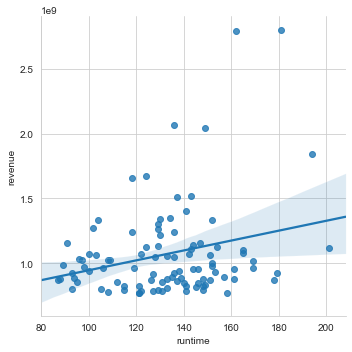

In [475]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#df.plot.scatter('runtime', 'revenue')


# sns.set_style('whitegrid')
# sns.lmplot(x='runtime', y='revenue', data=df)